<center> <h1>Trabajo final para la asignatura APBD</h1> </center>
<center> <h3>Máster en Data Science y Big Data. CFP-Universidad de Sevilla</h3> </center>
<p style="text-align: center;">Autor: Inmaculada Perea Fernández</p>
<p style="text-align: center;">(Julio 2017)</p>


# Tabla de contenidos

1. [Descripción del problema](#descripcion)

2. [Inicio sesión Spark](#inicio)

3. [Lectura de datos y exploración](#exploracion)

4. [Preprocesado](#preprocesado)

    4.1. [Valores perdidos (missings)](#missings)
    
    4.2. [Conversión a tipo numérico](#numerico)
    
    4.3. [Escalado](#escalado)
    
    4.4. [Convertir features en vector](#features)
    
5. [Selección de variables](#seleccion)

6. [Modelos](#modelos)

    6.1. [Ajuste de parámetros](#ajuste)
    
    6.2. [Evaluación](#evaluacion)
       
7. [Cierre sesión spark](#cierre)


<a id='descripcion'></a>

# 1. Descripción del problema

El objetivo de este trabajo es practicar con las diferentes herramientas que *Spark* nos proporciona para el procesamiento distribuido de grandes cantidades de datos, y para la aplicación de técnicas de machine learning. La obtención de predicciones óptimas es un objetivo secundario aunque se valorará positivamente.

El conjunto de datos elegido es uno de los datasets de aprendizaje de kaggle, en el que el objetivo es predecir el precio de venta de viviendas a partir de sus características. Para más información ir a https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Las APIs de Spark más importantes para este trabajo serán la API de *DataFrames* y la API de *ML* para DataFrames. También tenemos a nuestra disposición la API *RDDs* para procesamiento a bajo nivel, y la API MLlib para RDDs.

<a id="inicio"></a>

# 2. Inicio sesión spark

Creamos la sesión spark como punto de entrada para poder trabajar con la API de DataFrame

In [1]:
import sys

# Ruta de la carpeta local Spark.
spark_path = 'C:/Users/inpf/spark-2.1.0-bin-hadoop2.7'

sys.path.append(spark_path + '/python')
sys.path.append(spark_path + '/python/lib/py4j-0.10.4-src.zip')

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("evaluacion_APBD_InmaPerea").getOrCreate()

spark

Comprobamos el número de cores asignados

In [2]:
spark.sparkContext.defaultParallelism

4

<a id="librerias"></a>

# 3. Carga de librerías

Cargamos las librerías que utilizaremos a lo largo de la práctica

In [187]:
from pyspark.sql import SQLContext
from pyspark.sql import Row

from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Se importa sum como agg_sum para evitar colisión de nombres
from pyspark.sql.functions import lit, col, count, sum as agg_sum
#from pyspark.sql.functions import expr, udf, regexp_extract
from pyspark.sql.functions import desc, avg, round as col_round
from pyspark.sql.functions import log1p

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import Evaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor

from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from math import sqrt
from operator import add
from time import time

<a id="reused"></a>
# 4. Métodos y variables reutilizables

## 4.1 Métodos

Método para obtener los valores perdidos en el dataset que recibe como entrada. Devuelve un diccionario con el nombre de la variable y el número de valores perdidos de dicha variable ordenado de mayor a menor número de valores perdidos.

In [52]:
# Devuelve los valores perdidos de la variable que recibe como entrada
def count_nulls(c):
    return agg_sum(col(c).isNull().cast(IntegerType())).alias(c)

def get_NAs(dataset):
    exprs = [count_nulls(c) for c in dataset.columns]
    count_NA = dataset.agg(*exprs).first().asDict()
    total_NA=sorted([(v, k) for k, v in count_NA.items() if v > 0], reverse=True)
    print('Número de variables con valores perdidos = {}'.format(len(total_NA)))
    return total_NA

Método para dibujar la distribución de categorías de una determinada variable. Recibe como entrada las diferentes clases y valores de dicha variable categórica.

In [17]:
def plot_freqs(categories, values, max_y):
    %matplotlib inline
    plt.bar(range(len(categories)), values, align='center')
    plt.xticks(range(len(categories)), categories)
    plt.ylim([0, max_y])

Muestra *nrows* filas del dataset que se le pasa como entrada.
* *dataset*: dataset de entrada
* *step*: número de variables que imprime en cada fila
* *nrows*: número de registros de datos que se muestran

In [30]:
def print_cols(dataset, step, nrows):
    cols = dataset.columns
    ncolumns=len(cols)
    for index in range(0, ncolumns, step):
        dataset.select(cols[index:index+step]).show(nrows) 

 Muestra un resumen estadístico de cada variable que compone el dataset que recibe como entrada
* *dataset*: dataset de entrada
* *step*: número de variables que imprime en cada fila

In [32]:
def print_cols_description(dataset, step):
    cols = dataset.columns
    ncolumns=len(cols)
    for index in range(0, ncolumns, step):
        dataset.describe(cols[index:index+step]).show()

Método que imprime por pantalla la información para una contenida variable en la lista de missings que se le pasa como entrada:
* *missings*: lista de missings conl a información a mostrar para todas las variables
* *variable*: nombre de la variable por la que se quiere filtrar

In [68]:
def print_missing_list(missigns, variable):
    print('Rows    Variable    Datatype    Percent\n')
    for i in range(len(missings)):
        if variable in missings[i][1]:
            print(missings[i])

La métrica a usar para la evaluación de soluciones es *RMSLE*. Esta métrica no se encuentra dentro de las que ofrece el objeto *RegressionEvaluator*, por lo que debemos definir nuestro propio evaluador (*MyEvaluator*)

In [18]:
class MyEvaluator(Evaluator):
   
    def __init__(self, predictionCol='prediction', targetCol='label'):        
        super(MyEvaluator, self).__init__()
        self.predictionCol=predictionCol
        self.targetCol=targetCol

        
    def _evaluate(self, dataset):
        error=sqrt(dataset.select(avg((log1p(dataset[self.targetCol]) - log1p(dataset[self.predictionCol])) ** 2)).first()[0])
        return error
 

## 4.2 Variables

Establecemos la semilla que usaremos para toda la práctica

In [19]:
global_seed = 123456789

Ruta a los ficheros de entrada y salida

In [20]:
data_path='./data/'
preprocessing_path='./preprocessing/'
output_path='./output/'

<a id="lectura"></a>

# 5. Lectura de datos

Para explorar uniremos ambos datasets train y test. Por tanto, cargaremos ambos datasets para su unión y posterior exploración.

In [21]:
train = spark.read.csv(data_path +'train.csv', header=True, inferSchema=True, nullValue="NA").cache()
test  = spark.read.csv(data_path +'test.csv', header=True, inferSchema=True, nullValue="NA").cache()

Comprobaremos si ambos datasets tienen las mismas dimensiones y esquema antes de unirlos

In [22]:
print('Numero columnas para cada conjunto de datos ')
print('- train = {}'.format(len(train.schema.fields)))
print('- test  = {}'.format(len(test.schema.fields)))

Numero columnas para cada conjunto de datos 
- train = 81
- test  = 80


Observamos que tienen dimensiones distintas, esto es debido a que en el conjunto *test* no existe la columna correspondiente a la variable respuesta *SalePrice*. Vamos a añadir dicha columna al conjunto *test*.

Consultamos el tipo de dato de la columna *SalePrice* para replicarlo en el conjunto test.

In [23]:
train.schema['SalePrice']

StructField(SalePrice,IntegerType,true)

Creamos la columna en el conjunto *test* con el mismo tipo que en el conjunto *train*

In [24]:
test = test.withColumn('SalePrice', lit(None).cast(IntegerType()))

Ahora comprobaremos los esquemas de ambos dataframes, el orden de las columnas y su tipo

In [25]:
compare = [False if (train_field != test_field) else True for test_field, train_field in zip (test.schema.fields, train.schema.fields)]
print('¿Ambos dataframes tienen el mismo esquema de datos? {}'.format(False not in compare))

¿Ambos dataframes tienen el mismo esquema de datos? True


In [26]:
full = train.union(test)

print("Número de filas de cada dataframe:")
print("- train = {}".format(train.count()))
print("- test  = {}".format(test.count()))
print("- full  = {}".format(full.count()))

Número de filas de cada dataframe:
- train = 1460
- test  = 1459
- full  = 2919


# 6. Exploración de los datos

El esquema del dataframe union de train + test

In [27]:
full.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [34]:
print("Número de variables= {}".format(len(full.columns)))

Número de variables= 81


Mostramos las 5 primeras filas de cada variable

In [31]:
print_cols(full, 7, 5)

+---+----------+--------+-----------+-------+------+-----+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|
+---+----------+--------+-----------+-------+------+-----+
|  1|        60|      RL|         65|   8450|  Pave| null|
|  2|        20|      RL|         80|   9600|  Pave| null|
|  3|        60|      RL|         68|  11250|  Pave| null|
|  4|        70|      RL|         60|   9550|  Pave| null|
|  5|        60|      RL|         84|  14260|  Pave| null|
+---+----------+--------+-----------+-------+------+-----+
only showing top 5 rows

+--------+-----------+---------+---------+---------+------------+----------+
|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|
+--------+-----------+---------+---------+---------+------------+----------+
|     Reg|        Lvl|   AllPub|   Inside|      Gtl|     CollgCr|      Norm|
|     Reg|        Lvl|   AllPub|      FR2|      Gtl|     Veenker|     Feedr|
|     IR1|        Lvl|   AllPub|   Inside|      Gtl|     Co

A continuación mostramos un resumen estadístico de cada variable

In [33]:
print_cols_description(full, 5)

+-------+-----------------+------------------+--------+------------------+-----------------+
|summary|               Id|        MSSubClass|MSZoning|       LotFrontage|          LotArea|
+-------+-----------------+------------------+--------+------------------+-----------------+
|  count|             2919|              2919|    2915|              2433|             2919|
|   mean|           1460.0|  57.1377183967112|    null| 69.30579531442663|10168.11408016444|
| stddev|842.7870430897713|42.517627829150314|    null|23.344904706927394|7886.996359105535|
|    min|                1|                20| C (all)|                21|             1300|
|    max|             2919|               190|      RM|               313|           215245|
+-------+-----------------+------------------+--------+------------------+-----------------+

+-------+------+-----+--------+-----------+---------+
|summary|Street|Alley|LotShape|LandContour|Utilities|
+-------+------+-----+--------+-----------+---------+


<a id="missings"></a>

# 7. Valores perdidos

En la lectura de los ficheros csv de datos especificamos "NA" como nullValue.

A continuación vamos a evaluar los valores perdidos del conjunto resultante de la unión de los datasets de test y entrenamiento.

In [40]:
get_NAs(full)

[(2909, 'PoolQC'),
 (2814, 'MiscFeature'),
 (2721, 'Alley'),
 (2348, 'Fence'),
 (1459, 'SalePrice'),
 (1420, 'FireplaceQu'),
 (486, 'LotFrontage'),
 (159, 'GarageYrBlt'),
 (159, 'GarageQual'),
 (159, 'GarageFinish'),
 (159, 'GarageCond'),
 (157, 'GarageType'),
 (82, 'BsmtExposure'),
 (82, 'BsmtCond'),
 (81, 'BsmtQual'),
 (80, 'BsmtFinType2'),
 (79, 'BsmtFinType1'),
 (24, 'MasVnrType'),
 (23, 'MasVnrArea'),
 (4, 'MSZoning'),
 (2, 'Utilities'),
 (2, 'Functional'),
 (2, 'BsmtHalfBath'),
 (2, 'BsmtFullBath'),
 (1, 'TotalBsmtSF'),
 (1, 'SaleType'),
 (1, 'KitchenQual'),
 (1, 'GarageCars'),
 (1, 'GarageArea'),
 (1, 'Exterior2nd'),
 (1, 'Exterior1st'),
 (1, 'Electrical'),
 (1, 'BsmtUnfSF'),
 (1, 'BsmtFinSF2'),
 (1, 'BsmtFinSF1')]

## 7.1 Variables con categoría *NA* válida

Obtenemos un total de 35 variables que presentan valores *NA*, sin embargo, al leer el fichero *data_description.txt*, que contiene una breve descripción de las variables, podemos extraer que muchas de las variables faltantes no son verdaderos missings, sino que corresponden a categorías permitidas, o representan la ausencia de una determinada característica, como por ejemplo piscina, garaje, valla, chimenea, sótano, etc.

A continuación definiremos una lista con los nombres de las variables para las que la categoría "NA" es válida, y por tanto las observaciones con este valor no serán tratadas como variables missing. 

In [42]:
allowed_NA=['Alley',
            'BsmtQual',
            'BsmtCond',
            'BsmtExposure',
            'BsmtFinType1',
            'BsmtFinType2',
            'FireplaceQu',
            'GarageType',
            'GarageFinish',
            'GarageQual',
            'GarageCond',
            'PoolQC',
            'Fence',
            'MiscFeature']

print('Número de variables con categoría NA permitida = {}'.format(len(allowed_NA)))

Número de variables con categoría NA permitida = 14


Comprobamos el tipo de variable

In [43]:
for var in allowed_NA:
    print(full.schema[var].dataType)

StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType


Confirmamos que todas son variables categóricas, como cabía esperar.

Vamos a cambiar la categoría *NA* de las variables anteriores a las categorías que se presentan a continuación, y que son más descriptivas.

In [46]:
new_NA_categories={'Alley':'noAccess',
                   'BsmtQual':'NoBasement',
                   'BsmtCond':'NoBasement',
                   'BsmtExposure':'NoBasement',
                   'BsmtFinType1':'NoBasement',
                   'BsmtFinType2':'NoBasement',
                   'FireplaceQu':'NoFireplace',
                   'GarageType': 'NoGarage',
                   'GarageFinish':'NoGarage',
                   'GarageQual':'NoGarage',
                   'GarageCond':'NoGarage',
                   'PoolQC':'NoPool',
                   'Fence':'NoFence',
                   'MiscFeature':'None'}

In [47]:
full=full.fillna(new_NA_categories)

Si consultamos nuevamente las variables con valores perdidos comprobamos que las variables anteriores ya no se encuentran en la lista

In [56]:
missings=get_NAs(full)
missings

Número de variables con valores perdidos = 21


[(1459, 'SalePrice'),
 (486, 'LotFrontage'),
 (159, 'GarageYrBlt'),
 (24, 'MasVnrType'),
 (23, 'MasVnrArea'),
 (4, 'MSZoning'),
 (2, 'Utilities'),
 (2, 'Functional'),
 (2, 'BsmtHalfBath'),
 (2, 'BsmtFullBath'),
 (1, 'TotalBsmtSF'),
 (1, 'SaleType'),
 (1, 'KitchenQual'),
 (1, 'GarageCars'),
 (1, 'GarageArea'),
 (1, 'Exterior2nd'),
 (1, 'Exterior1st'),
 (1, 'Electrical'),
 (1, 'BsmtUnfSF'),
 (1, 'BsmtFinSF2'),
 (1, 'BsmtFinSF1')]

El número de variables con valores perdidos se ha reducido de 35 a 21.

A continuación realizaremos una inspección de cada una de las variables con valores perdidos para obtener el valor a imputar más idóneo.

## 7.2 Variable missing *SalePrice*

Los valores 1459 valores perdidos que obtenemos para la variable objetivo *SalePrice* pertenecen al conjunto test.

Vamos a asegurarnos de que es así realizando las siguientes comprobaciones:

In [57]:
print('Número de observaciones conjunto test = {}'.format(test.count()))

Número de observaciones conjunto test = 1459


In [58]:
print('Número de valores perdidos para la variable SalePrice en el conjunto train = {}'.format\
      (train.agg(agg_sum(col('SalePrice').isNull().cast(IntegerType())).alias('SalePrice')).first().SalePrice))

Número de valores perdidos para la variable SalePrice en el conjunto train = 0


Por tanto, podemos eliminar la variable *SalePrice* de la lista de missings

In [59]:
if (1459, 'SalePrice') in missings:
    missings.remove((1459, 'SalePrice'))
   
print('Número de variables con valores perdidos = {} '.format(len(missings)))
missings

Número de variables con valores perdidos = 20 


[(486, 'LotFrontage'),
 (159, 'GarageYrBlt'),
 (24, 'MasVnrType'),
 (23, 'MasVnrArea'),
 (4, 'MSZoning'),
 (2, 'Utilities'),
 (2, 'Functional'),
 (2, 'BsmtHalfBath'),
 (2, 'BsmtFullBath'),
 (1, 'TotalBsmtSF'),
 (1, 'SaleType'),
 (1, 'KitchenQual'),
 (1, 'GarageCars'),
 (1, 'GarageArea'),
 (1, 'Exterior2nd'),
 (1, 'Exterior1st'),
 (1, 'Electrical'),
 (1, 'BsmtUnfSF'),
 (1, 'BsmtFinSF2'),
 (1, 'BsmtFinSF1')]

A continuación vamos a incorporar información adicional a nuestra lista de variables missings. Se va a añadir el tipo de variable y el porcentaje de missings sobre el total de observaciones.

In [60]:
full_size=full.count()

print('Rows    Variable    Datatype    Percent')
for i in range(len(missings)):
    missings[i]=(missings[i][0], missings[i][1], full.schema[missings[i][1]].dataType, round((missings[i][0]/full_size)*100, 2))

missings

Rows    Variable    Datatype    Percent


[(486, 'LotFrontage', IntegerType, 16.65),
 (159, 'GarageYrBlt', IntegerType, 5.45),
 (24, 'MasVnrType', StringType, 0.82),
 (23, 'MasVnrArea', IntegerType, 0.79),
 (4, 'MSZoning', StringType, 0.14),
 (2, 'Utilities', StringType, 0.07),
 (2, 'Functional', StringType, 0.07),
 (2, 'BsmtHalfBath', IntegerType, 0.07),
 (2, 'BsmtFullBath', IntegerType, 0.07),
 (1, 'TotalBsmtSF', IntegerType, 0.03),
 (1, 'SaleType', StringType, 0.03),
 (1, 'KitchenQual', StringType, 0.03),
 (1, 'GarageCars', IntegerType, 0.03),
 (1, 'GarageArea', IntegerType, 0.03),
 (1, 'Exterior2nd', StringType, 0.03),
 (1, 'Exterior1st', StringType, 0.03),
 (1, 'Electrical', StringType, 0.03),
 (1, 'BsmtUnfSF', IntegerType, 0.03),
 (1, 'BsmtFinSF2', IntegerType, 0.03),
 (1, 'BsmtFinSF1', IntegerType, 0.03)]

## 7.3 Variables missing *Bsmt*

* **BsmtUnfSF**: superficie sin finalizar en el sótano (ft2)
* **BsmtFinSF2**: superficie finalizada tipo 2 (ft2)
* **BsmtFinSF1**: superficie finalizada tipo 1 (ft2)
* **BsmtFullBath**: baños completos en el sótano
* **BsmtHalfBath**: baños en el sótano
* **TotalBsmtSF**: superficie total del sótano (ft2)

In [69]:
print_missing_list(missings, 'Bsmt')

Rows    Variable    Datatype    Percent

(2, 'BsmtHalfBath', IntegerType, 0.07)
(2, 'BsmtFullBath', IntegerType, 0.07)
(1, 'TotalBsmtSF', IntegerType, 0.03)
(1, 'BsmtUnfSF', IntegerType, 0.03)
(1, 'BsmtFinSF2', IntegerType, 0.03)
(1, 'BsmtFinSF1', IntegerType, 0.03)


Vemos que todas ellas son variables **numéricas**.

Separamos en 2 conjutos distintos, uno en el que no existan variables *Bsmt* con valores perdidos (*no_miss_bsmt*) y otro en el que sólo estén los valores perdidos de dichas variables (*miss_bsmt*)

In [64]:
miss_bsmt = full.filter( full.BsmtUnfSF.isNull()    | full.BsmtFinSF2.isNull()   | full.BsmtFinSF1.isNull() |
                         full.BsmtFullBath.isNull() | full.BsmtHalfBath.isNull() | full.TotalBsmtSF.isNull() )

no_miss_bsmt = full.filter( full.BsmtUnfSF.isNotNull()     & full.BsmtFinSF2.isNotNull()   & full.BsmtFinSF1.isNotNull() |
                            full.BsmtFullBath.isNotNull()  & full.BsmtHalfBath.isNotNull() & full.TotalBsmtSF.isNotNull() )

A continuación veamos los valores que toman todas las variables Bsmt para los regristros con valores perdidos que hemos encontrado. En esta selección que se realizará a continuación se han incluido todas las variables Bsmt, no solamente las que tienen valores perdidos.

In [65]:
miss_bsmt.select(['BsmtQual',
                  'BsmtCond',
                  'BsmtExposure',
                  'BsmtFinType1',
                  'BsmtFinType2']).show()
                  
miss_bsmt.select(['BsmtFinSF1',
                  'BsmtFinSF2',
                  'BsmtUnfSF',
                  'TotalBsmtSF',
                  'BsmtFullBath',
                  'BsmtHalfBath']).show()


+----------+----------+------------+------------+------------+
|  BsmtQual|  BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinType2|
+----------+----------+------------+------------+------------+
|NoBasement|NoBasement|  NoBasement|  NoBasement|  NoBasement|
|NoBasement|NoBasement|  NoBasement|  NoBasement|  NoBasement|
+----------+----------+------------+------------+------------+

+----------+----------+---------+-----------+------------+------------+
|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|BsmtFullBath|BsmtHalfBath|
+----------+----------+---------+-----------+------------+------------+
|      null|      null|     null|       null|        null|        null|
|         0|         0|        0|          0|        null|        null|
+----------+----------+---------+-----------+------------+------------+



Comprobamos que las observaciones de las variables missing *Bsmt* (sótano) corresponden a las 2 únicas observaciones anteriores. Las variables informadas nos dan como característica común la ausencia de sótano, por tanto para las variables missing bajo estudio el único valor que tiene sentido imputar es 0, puesto que denota la ausencia de sotano y por tanto de baños en el sótano, superficie total, superficie construida o por contruir en el sótano

Creamos una diccionario *imputation_dict* donde iremos añadiendo el valor a imputar en cada una de las variables missing que estamos analizando para al final del análisis imputar los valores.

In [66]:
imputation_dict={}

imputation_dict['BsmtFinSF1']=0
imputation_dict['BsmtFinSF2']=0
imputation_dict['BsmtUnfSF']=0
imputation_dict['TotalBsmtSF']=0
imputation_dict['BsmtFullBath']=0
imputation_dict['BsmtHalfBath']=0

## 7.4 Variable missing *Electrical*

* **Electrical**: sistema eléctrico (SBrkr, FuseA, FuseF, FuseP, Mix)

In [83]:
print_missing_list(missings, 'Electrical')

Rows    Variable    Datatype    Percent

(1, 'Electrical', StringType, 0.03)


In [84]:
miss_electrical = full.filter(full.Electrical.isNull())

no_miss_electrical = full.filter(full.Electrical.isNotNull())

En primer lugar confirmaremos que el valor perdido en la variable *Electrical* no se debe a la ausencia de instalación eléctrica. Como podemos observar a continuación, la variable *Utilities* para la observación en la que Electrical es null toma el valor *AllPub*, lo cual quiere decir que la vivienda dispone de todos los suministros (luz, agua, gas, etc)

In [85]:
miss_electrical.select(['Utilities', 'Electrical']).show(1)

+---------+----------+
|Utilities|Electrical|
+---------+----------+
|   AllPub|      null|
+---------+----------+



Vamos a inspeccionar los datos para encontrar el mejor valor para imputar el valor perdido.

En primer lugar veamos cómo están distribuidas las categorías de la variable *Electrical* en el dataframe en la que no hay valores null de *Electrical*

In [86]:
freq_table_electrical = no_miss_electrical.groupby('Electrical').count().collect()
freq_table_electrical

[Row(Electrical='Mix', count=1),
 Row(Electrical='FuseF', count=50),
 Row(Electrical='SBrkr', count=2671),
 Row(Electrical='FuseP', count=8),
 Row(Electrical='FuseA', count=188)]

Convertimos a diccionario para facilitar la llamada a la función plot_freqs que se ha definido

In [87]:
freq_electrical={row.Electrical : row['count'] for row in freq_table_electrical}

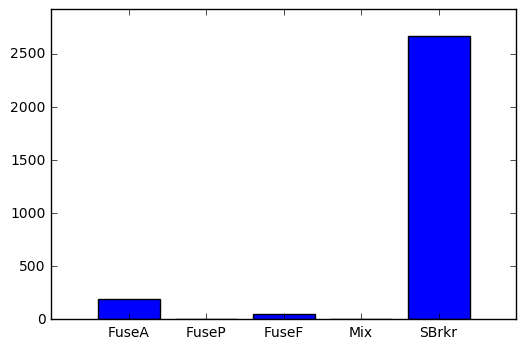

In [88]:
plot_freqs(freq_electrical.keys(), freq_electrical.values(), sum(freq_electrical.values()))

Observamos que la variable *Electrical* está muy desbalanceada, en su mayor parte las observaciones corresponden a la categoría *SBrkr*.

La categoría mayoritaria es *SBrkr*, podríamos imputar este valor, pero vamos a seguir inspeccionando los datos para asegurarnos de que elegimos el valor mas apropiado para imputar el missing detectado en esta variable.

Veamos qué valores toman algunas de las variables que intuitivamente sospechamos puedan tener relación con *Electrical*

In [89]:
miss_electrical.select(['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 
                       'YearRemodAdd']).show(1)
                        
miss_electrical.select(['MSZoning', 'Heating', 'CentralAir', 'MiscFeature', 'Electrical']).show(1)

+--------+----------+-----------+-----------+---------+------------+
|BldgType|HouseStyle|OverallQual|OverallCond|YearBuilt|YearRemodAdd|
+--------+----------+-----------+-----------+---------+------------+
|    1Fam|      SLvl|          5|          5|     2006|        2007|
+--------+----------+-----------+-----------+---------+------------+

+--------+-------+----------+-----------+----------+
|MSZoning|Heating|CentralAir|MiscFeature|Electrical|
+--------+-------+----------+-----------+----------+
|      RL|   GasA|         Y|       None|      null|
+--------+-------+----------+-----------+----------+



La variable *MiscFeature* la hemos incluido para comprobar si la vivienda tenía alguna instalación con necesidades eléctricas especiales, pero comprobamos que no es así. 

La variable *MSZoning* la añadimos para comprobar que la vivienda no estaba situada en una zona agrícola o industrial con características especiales que pudieran influir en la instalación electrica, pero comprobamos que no es asi.

*Heating* toma el valor *GasA*, por lo que no se utiliza la instalación eléctrica para la calefacción de la vivienda, sin embargo *CentralAir* toma el valor *Y*, por lo que podría necesitar unas características especiales en cuanto a sistema eléctrico.

Después de inspeccionar los valores anteriores vamos a comprobar cómo se distribuyen las categorias de Electrical cuando la vivienda fue construida (*YearBuilt*) o remodelada (*YearRemodAdd*) a partir del año 2006. También filtraremos por las variables *OverallQual* y *OverallCond*, que nos dan idea de las calidades de la vivienda. También filtraremos por *Heating* y *CentralAir*. 

El resto de variables consultadas no las tendremos en cuenta en el filtro porque parecen bastantes genéricas y no aportan demasiada información.

In [90]:
no_miss_electrical.filter(
    ((no_miss_electrical.YearBuilt >= 2006) | (no_miss_electrical.YearRemodAdd >= 2006))&
    ((no_miss_electrical.OverallQual== 5) | (no_miss_electrical.OverallCond==5)) &
    ((no_miss_electrical.BldgType=='1Fam') | (no_miss_electrical.HouseStyle=='SLvl')) &
    (no_miss_electrical.Heating=='GasA') & (no_miss_electrical.CentralAir=='Y')).groupBy('Electrical').count().show()

+----------+-----+
|Electrical|count|
+----------+-----+
|     FuseF|    1|
|     SBrkr|  360|
+----------+-----+



Observamos que la clase *SBrkr* es mayoritaria para las características filtradas, por tanto, tomaremos *SBrkr* como valor de imputación para la observación faltante de la variable *Electrical*

In [91]:
imputation_dict['Electrical']='SBrkr'

## 7.5 Variables missing *Exterior*

* **Exterior2nd**: cubierta exterior de la vivienda (si existe más de un material)
* **Exterior1st**: cubierta exterior de la vivienda

In [92]:
print_missing_list(missings, 'Exterior')        

Rows    Variable    Datatype    Percent

(1, 'Exterior2nd', StringType, 0.03)
(1, 'Exterior1st', StringType, 0.03)


In [93]:
miss_exterior = full.filter(full.Exterior2nd.isNull() | full.Exterior1st.isNull())
no_miss_exterior = full.filter(full.Exterior2nd.isNotNull() & full.Exterior1st.isNotNull())

Calculamos la categoría mayoritaria en la variable *Exterior1st*

In [94]:
exterior1_cat_dict={row.Exterior1st : row['count'] for row in no_miss_exterior.groupby('Exterior1st').count().collect()}
exterior1_cat_dict=sorted([(v,k) for (k,v) in exterior1_cat_dict.items()], reverse=True)
exterior1_cat_dict

[(1025, 'VinylSd'),
 (450, 'MetalSd'),
 (442, 'HdBoard'),
 (411, 'Wd Sdng'),
 (221, 'Plywood'),
 (126, 'CemntBd'),
 (87, 'BrkFace'),
 (56, 'WdShing'),
 (44, 'AsbShng'),
 (43, 'Stucco'),
 (6, 'BrkComm'),
 (2, 'Stone'),
 (2, 'CBlock'),
 (2, 'AsphShn'),
 (1, 'ImStucc')]

Calculamos la categoría mayoritaria en la variable *Exterior2nd*

In [95]:
exterior2_cat_dict={row.Exterior2nd : row['count'] for row in no_miss_exterior.groupby('Exterior2nd').count().collect()}
exterior2_cat_dict=sorted([(v,k) for (k,v) in exterior2_cat_dict.items()], reverse=True)
exterior2_cat_dict

[(1014, 'VinylSd'),
 (447, 'MetalSd'),
 (406, 'HdBoard'),
 (391, 'Wd Sdng'),
 (270, 'Plywood'),
 (126, 'CmentBd'),
 (81, 'Wd Shng'),
 (47, 'Stucco'),
 (47, 'BrkFace'),
 (38, 'AsbShng'),
 (22, 'Brk Cmn'),
 (15, 'ImStucc'),
 (6, 'Stone'),
 (4, 'AsphShn'),
 (3, 'CBlock'),
 (1, 'Other')]

Exploraremos los valores de las variables que intuimos pueden estar relacionadas con *Exterior2nd* y *Exterior1st* para el registro con valor perdido.

In [96]:
miss_exterior.select(['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MiscFeature']).show(5)
miss_exterior.select(['RoofStyle', 'RoofMatl', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'MSZoning']).show(5)

+--------+----------+-----------+-----------+---------+------------+-----------+
|BldgType|HouseStyle|OverallQual|OverallCond|YearBuilt|YearRemodAdd|MiscFeature|
+--------+----------+-----------+-----------+---------+------------+-----------+
|    1Fam|    1Story|          5|          7|     1940|        2007|       None|
+--------+----------+-----------+-----------+---------+------------+-----------+

+---------+--------+----------+----------+---------+---------+--------+
|RoofStyle|RoofMatl|MasVnrType|MasVnrArea|ExterQual|ExterCond|MSZoning|
+---------+--------+----------+----------+---------+---------+--------+
|     Flat| Tar&Grv|      None|         0|       TA|       TA|      RL|
+---------+--------+----------+----------+---------+---------+--------+



Vamos a filtrar los valores no perdidos para encontrar un registro similar al perdido, para no hacer una búsqueda tan restrictiva, agrupamos el resto de variables que estamos inspeccionando por temática, e imponemos que las variables que representan información similar se cumpla una u otra (no ambas a la vez, uso de OR en la condición).

In [97]:
no_miss_exterior.filter( ((no_miss_exterior.BldgType == '1Fam') | (no_miss_exterior.HouseStyle == '1Story')) &
                         ((no_miss_exterior.OverallQual == 5) | (no_miss_exterior.OverallCond== 7)) &
                         ((no_miss_exterior.YearBuilt>=1940) | (no_miss_exterior.YearRemodAdd>=2007)) &
                         ((no_miss_exterior.RoofStyle == 'Flat') | (no_miss_exterior.RoofMatl == 'Tar&Grv')) &
                         ((no_miss_exterior.MasVnrType == 'None') | (no_miss_exterior.MasVnrArea == 0)) &
                         ((no_miss_exterior.ExterQual == 'TA')  | (no_miss_exterior.ExterCond == 'TA')) &
                         (no_miss_exterior.MSZoning == 'RL') ).groupBy('Exterior1st').count().show()

+-----------+-----+
|Exterior1st|count|
+-----------+-----+
|    WdShing|    1|
|    Plywood|    2|
|    Wd Sdng|    2|
|    BrkFace|    1|
+-----------+-----+



Las dos categorías más probables para el valor perdido de *Exterior1st* son: *Plywood* y *Wd Sdng*, para desempatar entre ambas nos quedamos con la categoría más frecuente entre ambas, es decir, nos quedamos con ***Wd Sdng***.

Repetimos el mismo proceso para la variable *Exterior2nd*:

In [98]:
no_miss_exterior.filter( ((no_miss_exterior.BldgType == '1Fam') | (no_miss_exterior.HouseStyle == '1Story')) &
                         ((no_miss_exterior.OverallQual == 5) | (no_miss_exterior.OverallCond== 7)) &
                         ((no_miss_exterior.YearBuilt>=1940) | (no_miss_exterior.YearRemodAdd>=2007)) &
                         ((no_miss_exterior.RoofStyle == 'Flat') | (no_miss_exterior.RoofMatl == 'Tar&Grv')) &
                         ((no_miss_exterior.MasVnrType == 'None') | (no_miss_exterior.MasVnrArea == 0)) &
                         ((no_miss_exterior.ExterQual == 'TA')  | (no_miss_exterior.ExterCond == 'TA')) &
                         (no_miss_exterior.MSZoning == 'RL') ).groupBy('Exterior2nd').count().show()

+-----------+-----+
|Exterior2nd|count|
+-----------+-----+
|    Plywood|    3|
|    Wd Shng|    1|
|    Wd Sdng|    2|
+-----------+-----+



En este caso la categoría más frecuente es ***Plywood***.

Guardamos los valores a imputar en el diccionario *imputation_dict*

In [99]:
imputation_dict['Exterior1st'] = 'Wd Sdng'
imputation_dict['Exterior2nd'] = 'Plywood'

## 7.6 Variables missing *Garage*

* **GarageYrBlt**: año en el que fue construido el garage
* **GarageCars**: tamaño del garage según capacidad de coches
* **GarageArea**: tamaño del garage (ft2)

In [100]:
print_missing_list(missings, 'Garage')

Rows    Variable    Datatype    Percent

(159, 'GarageYrBlt', IntegerType, 5.45)
(1, 'GarageCars', IntegerType, 0.03)
(1, 'GarageArea', IntegerType, 0.03)


Vamos a estudiar en primer lugar los missings de las variables *GarageCars* y *GarageArea* que sólo presentan una observación y a continuación analizaremos los 159 registros con valores perdidos de la variable *GarageYrBlt*

In [101]:
miss_garage = full.filter(full.GarageCars.isNull() | full.GarageArea.isNull())
no_miss_garage = full.filter(full.GarageCars.isNotNull() & full.GarageArea.isNotNull())

In [102]:
miss_garage.select(['GarageQual',
                    'GarageCond',
                    'GarageType',
                    'GarageFinish',
                    'GarageCars',
                    'GarageArea',
                    'GarageYrBlt']).show(5)

+----------+----------+----------+------------+----------+----------+-----------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|
+----------+----------+----------+------------+----------+----------+-----------+
|  NoGarage|  NoGarage|    Detchd|    NoGarage|      null|      null|       null|
+----------+----------+----------+------------+----------+----------+-----------+



Observamos que los valores perdidos de las variables *GarageCars* y *GarageArea* pertenecen a la misma observación. En dicha observación el resto de variables relativas al garage nos informan de la no existencia de garage. En ese caso el tamaño del garage, que es lo que representan las variables que estamos estudiando, será igual a 0. 

Por tanto, decidimos imputar el valor 0 a los valores perdidos de las variables *GarageCars* y *GarageArea*, lo añadimos al diccionario *imputation_dict*.

En la inspección anterior vemos que la variable *GarageType* toma el valor *Detchd* (garage independiente a la vivienda), mientras que el resto de variables relativas al garage (*GarageQual*, *GarageCond*, etc.) toman el valor *NoGarage*, este registro no parece consistente, el valor de *GarageType* debería ser también *NoGarage*

In [103]:
miss_garage.select(['GarageQual',
                    'GarageCond',
                    'GarageType',
                    'GarageFinish',
                    'GarageCars',
                    'GarageArea',
                    'GarageYrBlt', 
                    'SalePrice']).show(5)

+----------+----------+----------+------------+----------+----------+-----------+---------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|SalePrice|
+----------+----------+----------+------------+----------+----------+-----------+---------+
|  NoGarage|  NoGarage|    Detchd|    NoGarage|      null|      null|       null|     null|
+----------+----------+----------+------------+----------+----------+-----------+---------+



El valor de *SalePrice* en este registro es null, lo que quiere decir que el resgistro pertenece al conjunto test, y por tanto, no vamos a modificar a modificar el dataset, pero sí habrá que tenerlo en cuenta a la hora de realizar las predicciones con el modelo que construyamos.

In [104]:
imputation_dict['GarageCars']=0
imputation_dict['GarageArea']=0

A continuación analizaremos los valores perdidos de la variable *GarageYrBlt*

In [105]:
miss_garageYearBlt = full.filter(full.GarageYrBlt.isNull())
no_miss_garageYearBlt = full.filter(full.GarageYrBlt.isNotNull())

In [106]:
miss_garageYearBlt.select(['GarageQual',
                           'GarageCond',
                           'GarageType',
                           'GarageFinish',
                           'GarageCars',
                           'GarageArea',
                           'GarageYrBlt']).show(10)

+----------+----------+----------+------------+----------+----------+-----------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|
+----------+----------+----------+------------+----------+----------+-----------+
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  No

Observamos que la variable *GarageYrBlt* no toma ningún valor si la vivienda no tiene garage, evidentemente, si no tiene garage, la variable que representa el año en el que se construyó el garage carece de sentido.

Vamos a explorar los registros que sí tienen valor para *GarageYrBlt* en busca de un año por defecto que haya sido introducido cuando la vivienda no tiene garage

In [107]:
no_miss_garageYearBlt.select('GarageQual','GarageCond', 'GarageType', 'GarageFinish', \
                             'GarageCars', 'GarageArea', 'GarageYrBlt')\
                     .filter((no_miss_garageYearBlt.GarageQual=='NoGarage')  | 
                             (no_miss_garageYearBlt.GarageCond=='NoGarage')  |
                             (no_miss_garageYearBlt.GarageType =='NoGarage') |
                             (no_miss_garageYearBlt.GarageFinish =='NoGarage') |
                             (no_miss_garageYearBlt.GarageCars == 0) |
                             (no_miss_garageYearBlt.GarageArea == 0)).show()

+----------+----------+----------+------------+----------+----------+-----------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|
+----------+----------+----------+------------+----------+----------+-----------+
+----------+----------+----------+------------+----------+----------+-----------+



Vemos que no hay un valor por defecto para el año de construcción del garage cuando la vivienda no tiene garage.

A continuación vamos a obtener la descripción de esta variable en la parte del dataset que no tiene valores perdidos.

In [108]:
no_miss_garageYearBlt.describe('GarageYrBlt').show()

+-------+------------------+
|summary|       GarageYrBlt|
+-------+------------------+
|  count|              2760|
|   mean|1978.1134057971014|
| stddev|25.574284723905112|
|    min|              1895|
|    max|              2207|
+-------+------------------+



Obtenemos un valor medio aproximado de año de construcción igual a *1978*. Un valor mínimo igual 1895 y un casualmente encontramos un valor máximo que representa un año en el futuro, parece que existe un outlier en la variable *GarageYrBlt*.

A continuación vamos a filtrar en cada uno de los datasets (train y test) para averiguar en cúal de ellos se encuentra el outlier.

In [111]:
train.select('GarageQual','GarageCond', 'GarageType', 'GarageFinish', 
            'GarageCars', 'GarageArea', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd').filter(train.GarageYrBlt>2017).show()

+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|YearBuilt|YearRemodAdd|
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+



In [112]:
test.select('GarageQual','GarageCond', 'GarageType', 'GarageFinish', 
            'GarageCars', 'GarageArea', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd').filter(test.GarageYrBlt>2017).show()

+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|YearBuilt|YearRemodAdd|
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
|        TA|        TA|    Attchd|         RFn|         2|       502|       2207|     2006|        2007|
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+



El outlier está en el conjunto test, por lo que habrá que tenerlo en cuenta a la hora de calcular las predicciones sobre este conjunto de datos una vez hayamos construido y ajustado nuestro modelo. Una buena opción para corregir este registro es dar el valor *2007*, ya que a la vista de los datos, la vivienda fue construida en 2006 y remodelada en el 2007 y en ese momento se construyó el garage, parece que hay una errata en un número en lugar de 2207 debería ser 2007.


Tenemos varias alternativas a la hora de solucionar los 159 registros missing de la variable *GarageYrBlt*. 
* Imputar la media de los años = 1978
* Imputar un 0 para indicar que si la vivienda no tiene garage, el año es un valor atípico
* Eliminar la variable *GarageYrBlt*
* Predecir el año usuando árboles de decisión

Ninguna de las soluciones es buena, podríamos eliminar la variable que es lo más sencillo, pero probaremos a dar el valor 0, ya que el porcentage de registros faltantes en esta variable no es muy alto (5,45%) y podría proporcionar información en la construcción del modelo. Tomar la media de los años también puede introducir error. Por tanto, tomaremos 0 como valor para imputar, y en función de los resultados que obtengamos con el modelo realizaremos pruebas de imputación con otros valores diferentes.

In [113]:
imputation_dict['GarageYrBlt'] = 0

## 7.7 Variable missing *KitchenQual*

* **KitchenQual**: Calidad de la cocina (Ex, Gd, TA, Fa, Po)

In [114]:
print_missing_list(missings, 'KitchenQual')

Rows    Variable    Datatype    Percent

(1, 'KitchenQual', StringType, 0.03)


In [115]:
miss_kitchen = full.filter(full.KitchenQual.isNull())
no_miss_kitchen = full.filter(full.KitchenQual.isNotNull())

Comprobemos cual es la clase mayoritaria para *KitchenQual* para las observaciones donde no existen valores perdidos:

In [116]:
kitchen_cat_dict={row.KitchenQual : row['count'] for row in no_miss_kitchen.groupby('KitchenQual').count().collect()}
kitchen_cat_dict=sorted([(v,k) for (k,v) in kitchen_cat_dict.items()], reverse=True)
kitchen_cat_dict

[(1492, 'TA'), (1151, 'Gd'), (205, 'Ex'), (70, 'Fa')]

La clase mayoritaria es *TA*, vamos a seguir inspeccionando para confirmar si este es un buen valor para imputar o no.

Las variables que intuitivamente podrían estar relacionadas con la calidad de la cocina son:

In [117]:
miss_kitchen.select(['Utilities',
                     'OverallQual',
                     'OverallCond',
                     'MasVnrType',
                     'MasVnrArea',
                     'Electrical',
                     'KitchenAbvGr',
                     'YearBuilt',
                     'YearRemodAdd',
                     'KitchenQual']).show(10)

+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+
|Utilities|OverallQual|OverallCond|MasVnrType|MasVnrArea|Electrical|KitchenAbvGr|YearBuilt|YearRemodAdd|KitchenQual|
+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+
|   AllPub|          5|          3|      None|         0|     SBrkr|           1|     1917|        1950|       null|
+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+



Veamos si encontramos un registro similar entre las observaciones del conjunto donde no hay valores perdidos para *KitchenQual*

In [118]:
no_miss_kitchen.select(['Utilities', 'OverallQual', 'OverallCond', 'MasVnrType','MasVnrArea',
                        'Electrical', 'KitchenAbvGr', 'YearBuilt', 'YearRemodAdd', 'KitchenQual'])\
               .filter((no_miss_kitchen.Utilities=='AllPub')  & 
                       (no_miss_kitchen.OverallQual==5)  &
                       (no_miss_kitchen.OverallCond ==3) &
                       (no_miss_kitchen.MasVnrType =='None') &
                       (no_miss_kitchen.MasVnrArea == 0) &
                       (no_miss_kitchen.Electrical == 'SBrkr') &
                       (no_miss_kitchen.KitchenAbvGr == 1) &
                       (no_miss_kitchen.YearBuilt >= 1917) &
                       (no_miss_kitchen.YearRemodAdd == 1950)).show()

+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+
|Utilities|OverallQual|OverallCond|MasVnrType|MasVnrArea|Electrical|KitchenAbvGr|YearBuilt|YearRemodAdd|KitchenQual|
+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+
|   AllPub|          5|          3|      None|         0|     SBrkr|           1|     1936|        1950|         TA|
+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+



Hemos obtenido un registro muy similar para el que la variable *KitchenQual* toma el valor *TA*, que además coincide con la categoría mayoritaria, por lo que imputaremos este valor.

Lo almacenamos en nuestro diccionario:

In [119]:
imputation_dict['KitchenQual']= 'TA'

## 7.8 Variable missing *SaleType*

* **SaleType**: Tipo de venta (tipo de contrato, intereses, garantías, etc.)

In [120]:
print_missing_list(missings, 'SaleType')

Rows    Variable    Datatype    Percent

(1, 'SaleType', StringType, 0.03)


In [121]:
miss_saletype = full.filter(full.SaleType.isNull())
no_miss_saletype = full.filter(full.SaleType.isNotNull())

Obtenemos la distribución de las distintas categorías de *SaleType*

In [123]:
saletype_cat_dict={row.SaleType : row['count'] for row in no_miss_saletype.groupby('SaleType').count().collect()}
saletype_cat_dict=sorted([(v,k) for (k,v) in saletype_cat_dict.items()], reverse=True)
saletype_cat_dict

[(2525, 'WD'),
 (239, 'New'),
 (87, 'COD'),
 (26, 'ConLD'),
 (12, 'CWD'),
 (9, 'ConLI'),
 (8, 'ConLw'),
 (7, 'Oth'),
 (5, 'Con')]

La categoría mayoritaria con bastante diferencia es *WD*. 

Las variables con las que podría estar relacionada esta variable son:

In [124]:
miss_saletype.select(['MoSold',
                      'YrSold',
                      'SaleCondition',
                      'MSSubClass',
                      'Neighborhood',
                      'MSZoning',
                      'SaleType']).show(10)

+------+------+-------------+----------+------------+--------+--------+
|MoSold|YrSold|SaleCondition|MSSubClass|Neighborhood|MSZoning|SaleType|
+------+------+-------------+----------+------------+--------+--------+
|    10|  2007|       Normal|        20|      Sawyer|      RL|    null|
+------+------+-------------+----------+------------+--------+--------+



In [125]:
no_miss_saletype.select(['MoSold', 'YrSold', 'SaleCondition', 'MSSubClass', 'Neighborhood', 'MSZoning', 'SaleType'])\
                .filter((no_miss_saletype.MoSold== 10)  & 
                        (no_miss_saletype.YrSold== 2007)  &
                        (no_miss_saletype.SaleCondition == 'Normal') &
                        (no_miss_saletype.MSSubClass == 20) &
                        (no_miss_saletype.Neighborhood == 'Sawyer') &
                        (no_miss_saletype.MSZoning == 'RL') ).show()

+------+------+-------------+----------+------------+--------+--------+
|MoSold|YrSold|SaleCondition|MSSubClass|Neighborhood|MSZoning|SaleType|
+------+------+-------------+----------+------------+--------+--------+
|    10|  2007|       Normal|        20|      Sawyer|      RL|      WD|
|    10|  2007|       Normal|        20|      Sawyer|      RL|      WD|
+------+------+-------------+----------+------------+--------+--------+



Hemos encontrado dos observaciones con características muy similares al del valor perdido y para los cuales la variable *SaleType* toma el valor *WD*. Por tanto, elegiremos dicha categoría para imputar, que como vimos además es la mayoritaria.

In [128]:
imputation_dict['SaleType']='WD'

## 5.9 Variable missing *Functional*

* **Functional**: Mide el grado de funcionalidad de la vivienda (asume siempre la categoría típica a menos que se justifique que carece de alguna característica)

In [129]:
print_missing_list(missings, 'Functional')

Rows    Variable    Datatype    Percent

(2, 'Functional', StringType, 0.07)


In [130]:
miss_functional = full.filter(full.Functional.isNull())
no_miss_functional = full.filter(full.Functional.isNotNull())

Calculemos la clase mayoritaria:

In [131]:
functional_cat_dict={row.Functional : row['count'] for row in no_miss_functional.groupby('Functional').count().collect()}
functional_cat_dict=sorted([(v,k) for (k,v) in functional_cat_dict.items()], reverse=True)
functional_cat_dict

[(2717, 'Typ'),
 (70, 'Min2'),
 (65, 'Min1'),
 (35, 'Mod'),
 (19, 'Maj1'),
 (9, 'Maj2'),
 (2, 'Sev')]

La clase mayoritaria es *Typ*.
Esta variable puede estar relacionada con muchas otras, porque es bastante genérica, dado que son solo 2 valores perdidos vamos a inspeccionar todas las variables y veamos si la vivienda en cuestión carece de alguna de funcionalidad, y si no es así le asignaremos la clase mayoritaria *Typ*

In [132]:
print_cols(miss_functional, 7, 5)

+----+----------+--------+-----------+-------+------+--------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|   Alley|
+----+----------+--------+-----------+-------+------+--------+
|2217|        20|    null|         80|  14584|  Pave|noAccess|
|2474|        50|      RM|         60|  10320|  Pave|    Grvl|
+----+----------+--------+-----------+-------+------+--------+

+--------+-----------+---------+---------+---------+------------+----------+
|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|
+--------+-----------+---------+---------+---------+------------+----------+
|     Reg|        Low|   AllPub|   Inside|      Mod|      IDOTRR|      Norm|
|     Reg|        Lvl|   AllPub|   Corner|      Gtl|      IDOTRR|    Artery|
+--------+-----------+---------+---------+---------+------------+----------+

+----------+--------+----------+-----------+-----------+---------+------------+
|Condition2|BldgType|HouseStyle|OverallQual|OverallCond|YearBuilt|YearRemodAdd

Las viviendas disponen de las características mínimas, tienen dormitorios, cocina, todos los suministros, instalación electrica, baños, etc. No dispone de características extra como piscina, sótano, garage, valla, etc.

Por tanto, asignaremos la clase mayoritaria *Typ*

In [133]:
imputation_dict['Functional']='Typ'

## 7.10 Variable missing *Utilities*

* **Utilities**: Tipo de suministros disponibles (agua, luz, gas, etc.)

In [134]:
print_missing_list(missings, 'Utilities')

Rows    Variable    Datatype    Percent

(2, 'Utilities', StringType, 0.07)


In [135]:
miss_utilities = full.filter(full.Utilities.isNull())
no_miss_utilities = full.filter(full.Utilities.isNotNull())

Calculamos la clase mayoritaria para *Utilities*

In [136]:
utilities_cat_dict={row.Utilities : row['count'] for row in no_miss_utilities.groupby('Utilities').count().collect()}
utilities_cat_dict=sorted([(v,k) for (k,v) in utilities_cat_dict.items()], reverse=True)
utilities_cat_dict

[(2916, 'AllPub'), (1, 'NoSeWa')]

En este caso vamos a asignar la clase mayoritaria para imputar, ya que claramente es la única clase existente en los datos.

In [137]:
imputation_dict['Utilities']='AllPub'

## 7.11 Variable missing *MSZoning*

* **MSZoning**: Identifica la clasificación de la vivienda según la zona en la que está ubicada (agrícola, comercial, residencial, industrial, etc.)

In [138]:
print_missing_list(missings, 'MSZoning')

Rows    Variable    Datatype    Percent

(4, 'MSZoning', StringType, 0.14)


In [139]:
miss_zoning = full.filter(full.MSZoning.isNull())
no_miss_zoning = full.filter(full.MSZoning.isNotNull())

Obtenemos la distribución de clases de la variable *MSZoning*

In [140]:
zoning_cat_dict={row.MSZoning : row['count'] for row in no_miss_zoning.groupby('MSZoning').count().collect()}
zoning_cat_dict=sorted([(v,k) for (k,v) in zoning_cat_dict.items()], reverse=True)
zoning_cat_dict

[(2265, 'RL'), (460, 'RM'), (139, 'FV'), (26, 'RH'), (25, 'C (all)')]

La clase mayoritaria es *RL*, es decir, zona residencial de baja densidad.

Las variable que más informacíon nos podría dar para encontrar el mejor valor para los valores perdidos de la variable *MSZoning* es *Neighborhood*, por tanto veamos el vecindario al que pertenecen las viviendas que presentan valores perdidos.

In [141]:
miss_zoning.select(['Neighborhood']).show(10)

+------------+
|Neighborhood|
+------------+
|      IDOTRR|
|      IDOTRR|
|      IDOTRR|
|     Mitchel|
+------------+



Vemos que las viviendas están ubicadas en el barrio *IDOTRR* o *Mitchel*, a continuación calculemos cuál es la calificación del suelo para estos barrios y le asignaremos esa categoría a los valores perdidos.

In [142]:
no_miss_zoning.filter((no_miss_zoning.Neighborhood=='IDOTRR') | 
                      (no_miss_zoning.Neighborhood=='Mitchel')).groupBy('MSZoning').count().show()

+--------+-----+
|MSZoning|count|
+--------+-----+
| C (all)|   22|
|      RL|  104|
|      RM|   77|
+--------+-----+



Imputaremos el valor *RL*

In [143]:
imputation_dict['MSZoning']='RL'

## 7.12 Variables missing *MasVnr*

* **MasVnrType**: Tipo de revestimiento (ladrillo, ladrillo visto, piedra, etc.)
* **MasVnrArea**: superficie de revestimiento (ft2)

In [144]:
print_missing_list(missings, 'MasVnr')

Rows    Variable    Datatype    Percent

(24, 'MasVnrType', StringType, 0.82)
(23, 'MasVnrArea', IntegerType, 0.79)


In [145]:
miss_masvnr = full.filter(full.MasVnrType.isNull() | full.MasVnrArea.isNull() )
no_miss_masvnr = full.filter(full.MasVnrType.isNotNull() & full.MasVnrArea.isNotNull())

Calculamos la clase mayoritaria para la variable *MasVnrType*

In [146]:
masvnr_cat_dict={row.MasVnrType : row['count'] for row in no_miss_masvnr.groupby('MasVnrType').count().collect()}
masvnr_cat_dict=sorted([(v,k) for (k,v) in masvnr_cat_dict.items()], reverse=True)
masvnr_cat_dict

[(1742, 'None'), (879, 'BrkFace'), (249, 'Stone'), (25, 'BrkCmn')]

La clase mayoritaria es *None*.

Veamos los valores que toman las variables que podrían estar relacionadas con *MasVnrArea* y *MasVnrType* para las observaciones missing:

In [147]:
miss_masvnr.select(['MSSubClass',
                    'Neighborhood',
                    'OverallQual',
                    'OverallCond',
                    'YearBuilt',
                    'Exterior1st',
                    'Exterior2nd',
                    'ExterQual',
                    'ExterCond',
                    'MasVnrType',
                    'MasVnrArea']).show(25)

+----------+------------+-----------+-----------+---------+-----------+-----------+---------+---------+----------+----------+
|MSSubClass|Neighborhood|OverallQual|OverallCond|YearBuilt|Exterior1st|Exterior2nd|ExterQual|ExterCond|MasVnrType|MasVnrArea|
+----------+------------+-----------+-----------+---------+-----------+-----------+---------+---------+----------+----------+
|        60|     Gilbert|          6|          5|     2002|    VinylSd|    VinylSd|       Gd|       TA|      null|      null|
|        20|     Crawfor|          6|          3|     1957|    Wd Sdng|      Stone|       Gd|       TA|      null|      null|
|        60|     Somerst|          7|          6|     2007|    CemntBd|    CmentBd|       Gd|       TA|      null|      null|
|        20|     SawyerW|          7|          5|     2003|    VinylSd|    VinylSd|       Gd|       TA|      null|      null|
|        20|     Somerst|          7|          5|     2007|    CemntBd|    CmentBd|       Gd|       TA|      null|    

Vamos a buscar los observaciones similares en el dataframe sin valores perdidos

In [149]:
no_miss_masvnr.select(['MSSubClass', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearBuilt',
                       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'MasVnrType', 'MasVnrArea'])\
                .filter((no_miss_masvnr.ExterCond=='TA') &
                        (no_miss_masvnr.ExterQual=='Gd') &
                        (no_miss_masvnr.Exterior2nd=='VinylSd') &
                        (no_miss_masvnr.Exterior1st=='VinylSd') &
                        ((no_miss_masvnr.YearBuilt>=1957) & (no_miss_masvnr.YearBuilt<=2007)) &
                        (no_miss_masvnr.OverallCond==5) &
                        (no_miss_masvnr.OverallQual>=6) & 
                        (no_miss_masvnr.OverallQual<=8) &
                        ((no_miss_masvnr.Neighborhood=='Gilbert') | (no_miss_masvnr.Neighborhood=='Crawfor') | 
                         (no_miss_masvnr.Neighborhood=='Somerst') | (no_miss_masvnr.Neighborhood=='NridgHt') | 
                         (no_miss_masvnr.Neighborhood=='CollgCr')) &
                        ((no_miss_masvnr.MSSubClass==60) | (no_miss_masvnr.MSSubClass==20))).groupBy('MasVnrType').count().show()

+----------+-----+
|MasVnrType|count|
+----------+-----+
|      None|  151|
|     Stone|   49|
|   BrkFace|  125|
+----------+-----+



La mayoria de las observaciones similares tiene como categoría mayoritaria *None*, por tanto utilizaremos este valor para imputar *MasVnrType*. Veamos qué valor damos a *MasVnrArea*.

In [150]:
no_miss_masvnr.select(['MasVnrType', 'MasVnrArea']).filter(no_miss_masvnr.MasVnrType=='None').show(5)

+----------+----------+
|MasVnrType|MasVnrArea|
+----------+----------+
|      None|         0|
|      None|         0|
|      None|         0|
|      None|         0|
|      None|         0|
+----------+----------+
only showing top 5 rows



In [151]:
no_miss_masvnr.select(['MasVnrType', 'MasVnrArea']).filter(no_miss_masvnr.MasVnrType=='None').groupBy('MasVnrType').count().show(5)

+----------+-----+
|MasVnrType|count|
+----------+-----+
|      None| 1742|
+----------+-----+



Todas las observaciones con valor *MasVnrType* igual a *None*, les corresponde un valor de *MasVnrArea* igual a 0, por tanto imputaremos los siguientes valores:

In [152]:
imputation_dict['MasVnrType']='None'
imputation_dict['MasVnrArea']=0

## 7.13 Variable missing *LotFrontage*

* **LotFrontage**: longitud de la calle en la que se encuentra la propiedad

In [153]:
print_missing_list(missings, 'LotFrontage')

Rows    Variable    Datatype    Percent

(486, 'LotFrontage', IntegerType, 16.65)


Esta variable presenta un alto porcentaje de valores perdidos (16,65%), por tanto, vamos a eliminarla del estudio, porque imputar tantos valores podría introducir error o sesgar los resultados.

## 7.14 Imputación de valores perdidos

Añadimos al diccionario imputation_dict los valores de las categorías NA válidas pero que hemos renombrado para más claridad

In [154]:
imputation_dict.update(new_NA_categories)

Los valores por los que imputamos cada una de las variables missing a continuación

In [155]:
imputation_dict

{'Alley': 'noAccess',
 'BsmtCond': 'NoBasement',
 'BsmtExposure': 'NoBasement',
 'BsmtFinSF1': 0,
 'BsmtFinSF2': 0,
 'BsmtFinType1': 'NoBasement',
 'BsmtFinType2': 'NoBasement',
 'BsmtFullBath': 0,
 'BsmtHalfBath': 0,
 'BsmtQual': 'NoBasement',
 'BsmtUnfSF': 0,
 'Electrical': 'SBrkr',
 'Exterior1st': 'Wd Sdng',
 'Exterior2nd': 'Plywood',
 'Fence': 'NoFence',
 'FireplaceQu': 'NoFireplace',
 'Functional': 'Typ',
 'GarageArea': 0,
 'GarageCars': 0,
 'GarageCond': 'NoGarage',
 'GarageFinish': 'NoGarage',
 'GarageQual': 'NoGarage',
 'GarageType': 'NoGarage',
 'GarageYrBlt': 0,
 'KitchenQual': 'TA',
 'MSZoning': 'RL',
 'MasVnrArea': 0,
 'MasVnrType': 'None',
 'MiscFeature': 'None',
 'PoolQC': 'NoPool',
 'SaleType': 'WD',
 'TotalBsmtSF': 0,
 'Utilities': 'AllPub'}

En este punto nos olvidaremos del conjunto test, sólo lo retomaremos para calcular las predicciones que subiremos a Kaggle. Imputaremos los valores perdidos en el conjunto train, utilizando la función *fillna* y el diccionario que hemos construido en los apartados anteriores.

In [156]:
imputed_df=train.fillna(imputation_dict)

A continuación borraremos la variable *LotFrontage* del dataframe de entrenamiento, tal y como vimos el porcentaje de valores perdidos es muy elevado, y hemos tomado la decisión de prescindir de dicha variable para nuestro estudio.

In [157]:
imputed_df2 = imputed_df.drop('LotFrontage')

Por último comprobamos que en el conjunto train ya no existen valores perdidos

In [158]:
sorted([(v, k) for k, v in imputed_df2.agg(*[count_nulls(c) for c in imputed_df2.columns]).first().asDict().items() if v > 0], reverse=True)

[]

Vamos a guardar nuestro dataset train ya limpio de valores perdidos en un fichero csv para poder usarlo en cualquier momento

In [159]:
imputed_df2.write.csv(preprocessing_path, header=True, mode='overwrite')

<a id="preprocesado"></a>

# 8. Preprocesado

En primer lugar recuperamos el conjunto de entranamienot ya limpio de missings

In [160]:
imputed_train_data = spark.read.csv(preprocessing_path, header=True, inferSchema=True).cache()

<a id="numerico"></a>

## 8.1 Conversión a tipo numérico

Para construir modelos es necesario convertir a numéricas las variables.

Vamos a usar *StringIndexer* para automatizar el proceso

A continuación vamos a extaer en dos listas distintas los nombres de las variables categóricas (*categ_var*) y de las variables numéricas (*num_var*)

In [162]:
all_features=imputed_train_data.columns

# Vector con las variables numéricas
num_var=[var for var in all_features if type(imputed_train_data.schema[var].dataType)==IntegerType]

# Vector con las variables categóricas
categ_var=[var for var in all_features if type(imputed_train_data.schema[var].dataType)==StringType]

print('Número de variables numéricas = {}'.format(len(num_var)))
print('Número de variables categóricas = {} '.format(len(categ_var)))


Número de variables numéricas = 37
Número de variables categóricas = 43 


In [163]:
num_var

['Id',
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

A continuación construiremos una lista con los StringIndexers que utilizaremos para convertir las variables categóricas a númericas

In [164]:
indexers=[StringIndexer(inputCol= var, outputCol=var + '_n') for var in categ_var]

<a id="seleccion"></a>

## 8.2 Selección de variables 

De momento no realizamos reducción de dimensionalidad seleccionando variables. Seleccionaremos todas las variables.

In [170]:
selected_features = num_var + [c+'_n' for c in categ_var]

Eliminamos las variables *Id* y *SalePrice* de las variables para predecir la variable objetivo *SalePrice*, una porque es la propia variable objetivo, y la otra porque no aporta información para nuestro estudio

In [171]:
selected_features.remove('Id')
selected_features.remove('SalePrice')

<a id="features"></a>

## 8.3 Convertir features en vector

In [172]:
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

<a id="escalado"></a>

## 8.4 Escalado

Usamos la clase StandardScaler para escalar nuestro vector de características.

In [173]:
standard_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaledFeatures')
standard_scaler

StandardScaler_4edb9a03abf71f6ccc9b

## 8.5 Pipeline preprocesado

In [174]:
preprocessing_stages= indexers + [assembler, standard_scaler]

In [175]:
pipeline = Pipeline(stages=preprocessing_stages)
pipeline

Pipeline_4c9eaa6933b2359d7720

## 8.6 Entrenamiento del pipeline de preprocesado

In [176]:
preprocessing_pl = pipeline.fit(imputed_train_data)
preprocessing_pl

PipelineModel_4807868c8ba8c2db4545

## 8.7 Transformación de los datos de entrenamiento

Aplicamos el pipeline de preprocesado a los datos train con valores missing imputados para convertir a numérico, seleccionar variables que utilizarán los modelos para predecir la variable objetivo, escalar los valores, y convertir las features a vector tal y como esperan los métodos de entrenamiento de los modelos y cálculo de predicciones con los que trabajaremos.

In [177]:
preprocesed_df=preprocessing_pl.transform(imputed_train_data)

Echamos un vistazo a al dataset preprocesado:

In [178]:
preprocesed_columns=selected_features + ['features', 'scaledFeatures']

step=7
for index in range(0, len(preprocesed_columns), step):
    preprocesed_df.select(preprocesed_columns[index:index+step]).show(5) 

+----------+-------+-----------+-----------+---------+------------+----------+
|MSSubClass|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|MasVnrArea|
+----------+-------+-----------+-----------+---------+------------+----------+
|        60|   8450|          7|          5|     2003|        2003|       196|
|        20|   9600|          6|          8|     1976|        1976|         0|
|        60|  11250|          7|          5|     2001|        2002|       162|
|        70|   9550|          7|          5|     1915|        1970|         0|
|        60|  14260|          8|          5|     2000|        2000|       350|
+----------+-------+-----------+-----------+---------+------------+----------+
only showing top 5 rows

+----------+----------+---------+-----------+--------+--------+------------+
|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|
+----------+----------+---------+-----------+--------+--------+------------+
|       706|         0|      150|

Observamos que todas las variables se han convertido a numérica y las operaciones de preprocesado se han aplicado sobre nuestro conjunto test.

# 9. Matriz de correlaciones

A continuación, una vez convertido a numérico y escalado, vamos a calcular la matriz de correlación para nuestro conjunto de datos.

In [181]:
preprocesed_rdd = preprocesed_df.select(selected_features).rdd.map(Vectors.dense) ### convertimos a rdd

pearson_corr = Statistics.corr(preprocesed_rdd, method="pearson")
pearson_corr_df = pd.DataFrame(pearson_corr, index=selected_features, columns=selected_features)
pearson_corr_df

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageType_n,GarageFinish_n,GarageQual_n,GarageCond_n,PavedDrive_n,PoolQC_n,Fence_n,MiscFeature_n,SaleType_n,SaleCondition_n
MSSubClass,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,-0.140759,...,0.164193,0.052038,0.055006,0.040650,0.025973,-0.001113,-0.100303,-0.016437,0.014963,0.004788
LotArea,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,-0.002618,...,-0.066204,0.046625,-0.040210,-0.055792,-0.002964,0.058232,-0.035421,0.089707,-0.012098,-0.016193
OverallQual,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,0.308159,...,-0.293393,0.275131,-0.160127,-0.226272,-0.200702,0.062375,-0.170554,-0.083121,0.075002,0.002462
OverallCond,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,-0.136841,...,0.003521,-0.173026,0.086357,0.023459,0.082132,-0.015231,0.142421,0.061981,-0.105673,-0.125835
YearBuilt,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,-0.049107,0.149040,...,-0.321568,0.342565,-0.349503,-0.317723,-0.396023,0.001374,-0.193985,-0.070932,0.081609,0.015943
YearRemodAdd,0.040581,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,-0.067759,0.181133,...,-0.182247,0.313004,-0.159714,-0.195652,-0.193616,0.011973,-0.146553,-0.087934,0.039722,-0.017517
MasVnrArea,0.023573,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,-0.071330,0.113862,...,-0.123286,0.146081,-0.139110,-0.111800,-0.140724,0.008207,-0.071418,-0.044700,0.033930,0.015323
BsmtFinSF1,-0.069836,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,-0.050117,-0.495251,...,-0.197154,0.134247,-0.146226,-0.133057,-0.175379,0.117715,-0.000065,-0.006777,0.019767,0.005293
BsmtFinSF2,-0.065649,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,-0.209294,...,-0.040819,-0.051147,-0.049336,-0.023178,-0.067842,0.069478,0.109056,0.009178,0.012186,-0.020424
BsmtUnfSF,-0.140759,-0.002618,0.308159,-0.136841,0.149040,0.181133,0.113862,-0.495251,-0.209294,1.000000,...,-0.057378,0.076618,0.037590,-0.007936,0.021160,-0.048045,-0.147854,-0.057738,0.066417,0.045331


Extraemos el triángulo superior de la matriz diagonal y ordenamos en orden descendente según la correlación entre variables.

In [225]:
corr_matrix = pearson_corr_df.corr()

# Calculamos el valor absoluto de las correlaciones, nos interesa el orden de magnitud, no el signo
abs_corr_matrix = corr_matrix.abs()

corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

# Mostramos las 10 parejas de variables que presentan mayor correlación
corr_pairs.head(10)

GarageCars     GarageArea       0.991890
PoolArea       PoolQC_n         0.985006
Exterior1st_n  Exterior2nd_n    0.976239
TotalBsmtSF    1stFlrSF         0.957777
GrLivArea      TotRmsAbvGrd     0.952482
Fireplaces     FireplaceQu_n    0.943324
GarageQual_n   GarageCond_n     0.935497
OverallQual    GarageCars       0.922072
MasVnrArea     MasVnrType_n     0.921225
YearBuilt      YearRemodAdd     0.919422
dtype: float64

Gráficamente se vería como se muestra a continuación, nos quedamos con las variables que presentan un índice de correlación superior a 0.8

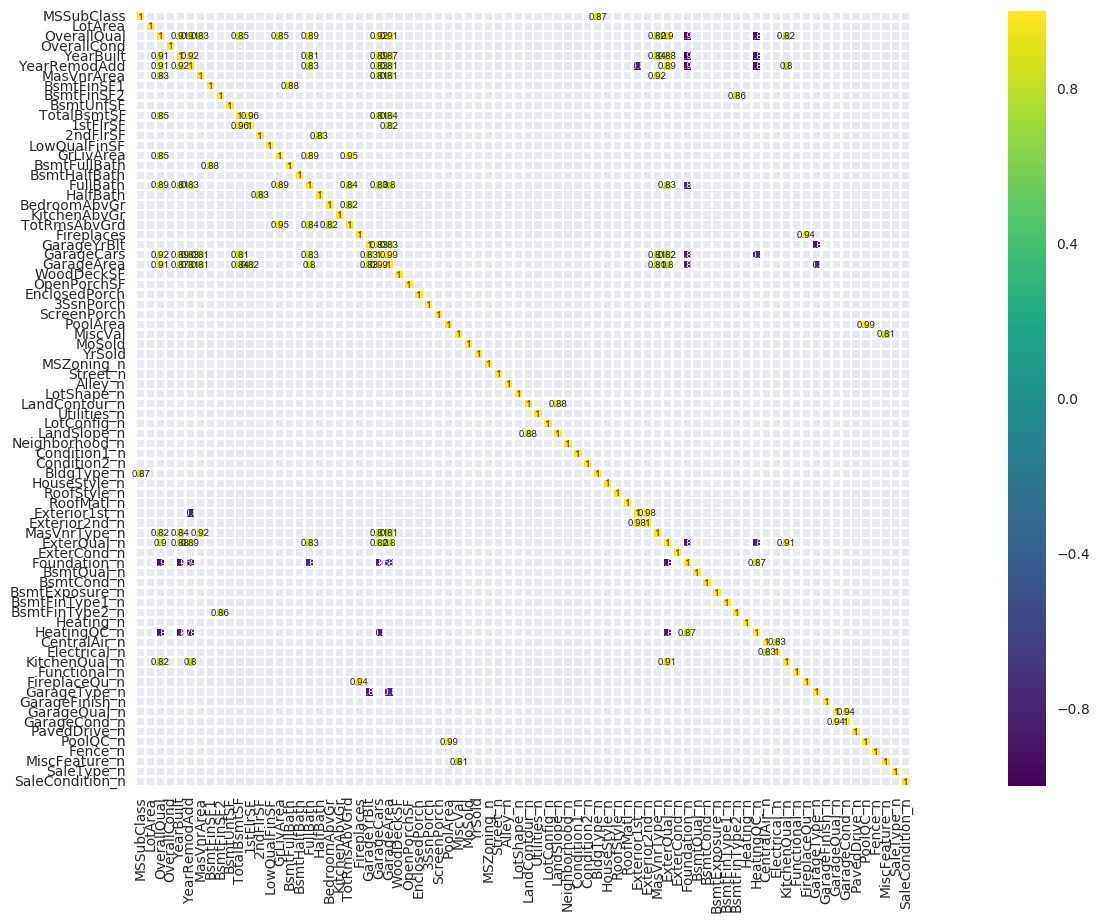

In [221]:
plt.figure(figsize=(25, 10))

sns.heatmap(corr_matrix[(corr_matrix >= 0.8) | (corr_matrix <= -0.8)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=1.2,
            annot=True, annot_kws={"size": 7}, square=True);

Existe un elevado número de variables correlacionadas entre sí. 

Algunas de estas variables pueden combinarse entre sí para reducir el número de variables, como por ejemplo *GarageCars*, *GarageArea*, *GarageQual_n*, *GarageCond_n*, *OverallQual*. O *YearBuilt* y *YearRemodAdd*.

Se deja para posteriores estudios aplicar técnicas de reducción de la dimensionalidad basándonos en la correlación entre las variables de nuestro problema.


<a id="modelos"></a>

# 8. Modelos

En este apartado vamos a aplicar 2 modelos distintos: **Random Forest** y **Gradien Boosting**. Realizaremos ajuste de parámetros de ambos modelos y mediremos cómo se ajusta cada uno de ellos, para porteriormente quedarnos con el que presente menor error.

## 8.1 Preparación de datasets (train y validation)

Nos quedamos con un dataset que contenga únicamente el vector de *features* y las *labels*, este dataset ya esta preparado para entrenar modelos.

In [227]:
feat_train_df = preprocessing_pl.transform(imputed_train_data)
feat_train_df = feat_train_df.select(feat_train_df.features, feat_train_df.SalePrice.alias('label'))
feat_train_df.show(3)

+--------------------+------+
|            features| label|
+--------------------+------+
|(78,[0,1,2,3,4,5,...|208500|
|(78,[0,1,2,3,4,5,...|181500|
|(78,[0,1,2,3,4,5,...|223500|
+--------------------+------+
only showing top 3 rows



Dividimos el conjunto de entrenamiento en 2: train y validation

In [228]:
train, validation = feat_train_df.randomSplit([0.8, 0.2], seed=global_seed)
print('Tamaño train: {}. Tamaño validation: {}'.format(train.count(), validation.count()))

Tamaño train: 1178. Tamaño validation: 282


## 8.2 RandomForestRegressor

**Construcción del modelo**

In [229]:
rf1 = RandomForestRegressor(predictionCol='pred_rf1', seed=global_seed)
rf1

RandomForestRegressor_4b118b83cb037cf1b962

In [230]:
print(rf1.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]. (default: auto)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories f

**Entrenamiento**

In [231]:
t0 = time()
rf1_model = rf1.fit(train)
tt = time() - t0

print('Tiempo entrenamiento {} sec.'.format(round(tt,2)))
rf1_model

Tiempo entrenamiento 5.52 sec.


RandomForestRegressionModel (uid=rfr_9ce65a0d8c12) with 20 trees

**Importancia de variables**

In [232]:
rf1_fi = pd.DataFrame({'feature': selected_features, 'importance_rf1': rf1_model.featureImportances.toArray()})
rf1_fi.sort_values(by='importance_rf1', ascending=False).head(10)

,feature,importance_rf1
2,OverallQual,0.221494
43,Neighborhood_n,0.135785
14,GrLivArea,0.099503
53,ExterQual_n,0.097798
65,KitchenQual_n,0.082550
24,GarageCars,0.062996
11,1stFlrSF,0.041991
25,GarageArea,0.031405
4,YearBuilt,0.022565
10,TotalBsmtSF,0.021371


**Predicción**

In [233]:
t0 = time()
validation = rf1_model.transform(validation)
tt = time() - t0

print('Tiempo predicción {} sec.'.format(round(tt,2)))

Tiempo predicción 0.46 sec.


In [234]:
validation.show(5)

+--------------------+------+------------------+
|            features| label|          pred_rf1|
+--------------------+------+------------------+
|(78,[0,1,2,3,4,5,...|200000|214731.91207226683|
|(78,[0,1,2,3,4,5,...|402000| 348402.8284919854|
|(78,[0,1,2,3,4,5,...|129000|181840.08411627333|
|(78,[0,1,2,3,4,5,...|155000|161290.43006911385|
|(78,[0,1,2,3,4,5,...|154000|144799.96596292165|
+--------------------+------+------------------+
only showing top 5 rows



## 8.3 Gradient-Boosted Trees Regressor (GBTs)

**Contrucción del modelo**

In [235]:
gbt1 = GBTRegressor(predictionCol='pred_gbt1', seed=global_seed)
gbt1

GBTRegressor_476988fc18795eeb3a64

In [236]:
print(gbt1.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: squared, absolute (default: squared)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxD

**Entrenamiento**

In [237]:
t0 = time()
gbt1_model = gbt1.fit(train)
tt = time() - t0

print('Tiempo entrenamiento {} sec.'.format(round(tt,2)))
gbt1_model

Tiempo entrenamiento 13.56 sec.


GBTRegressionModel (uid=GBTRegressor_476988fc18795eeb3a64) with 20 trees

**Importancia de variables**

In [239]:
gbt1_fi = pd.DataFrame({'feature': selected_features, 'importance_gbt1': gbt1_model.featureImportances.toArray()})
gbt1_fi.sort_values(by='importance_gbt1', ascending=False).head(10)

,feature,importance_gbt1
43,Neighborhood_n,0.148282
2,OverallQual,0.111338
14,GrLivArea,0.065198
7,BsmtFinSF1,0.043419
1,LotArea,0.043281
50,Exterior1st_n,0.036536
3,OverallCond,0.026588
41,LotConfig_n,0.025724
25,GarageArea,0.022292
26,WoodDeckSF,0.022045


Vamos a añadir también las importancias que obtuvimos con el modelo anterior (RF)

In [240]:
importance_df=pd.merge(rf1_fi, gbt1_fi, on='feature')
importance_df.sort_values(by='importance_gbt1', ascending=False).head(10)

,feature,importance_rf1,importance_gbt1
43,Neighborhood_n,0.135785,0.148282
2,OverallQual,0.221494,0.111338
14,GrLivArea,0.099503,0.065198
7,BsmtFinSF1,0.010997,0.043419
1,LotArea,0.016982,0.043281
50,Exterior1st_n,0.006243,0.036536
3,OverallCond,0.001152,0.026588
41,LotConfig_n,0.000333,0.025724
25,GarageArea,0.031405,0.022292
26,WoodDeckSF,0.002054,0.022045


**Predicción**

In [241]:
t0 = time()
validation = gbt1_model.transform(validation)
tt = time() - t0

print('Tiempo predicción {} sec.'.format(round(tt,2)))

Tiempo predicción 0.13 sec.


In [242]:
validation.show(5)

+--------------------+------+------------------+------------------+
|            features| label|          pred_rf1|         pred_gbt1|
+--------------------+------+------------------+------------------+
|(78,[0,1,2,3,4,5,...|200000|214731.91207226683|251923.27980401702|
|(78,[0,1,2,3,4,5,...|402000| 348402.8284919854| 302628.3670832336|
|(78,[0,1,2,3,4,5,...|129000|181840.08411627333|136736.36435388066|
|(78,[0,1,2,3,4,5,...|155000|161290.43006911385|152425.03809573918|
|(78,[0,1,2,3,4,5,...|154000|144799.96596292165|155398.35801047605|
+--------------------+------+------------------+------------------+
only showing top 5 rows



<a id="ajuste"></a>

## 8.4 Ajuste de parámetros

### 8.4.1 Ajuste RandomForestRegressor

**Construcción del modelo**

In [243]:
rf2 = RandomForestRegressor(predictionCol='pred_rf2', seed=global_seed)
rf2

RandomForestRegressor_46c8a7e282db803f1486

In [244]:
print(rf2.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]. (default: auto)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories f

In [245]:
paramGrid = ParamGridBuilder().addGrid(rf2.maxDepth, [5, 7, 10]) \
                              .addGrid(rf2.numTrees, [10, 50, 100])\
                              .addGrid(rf2.minInfoGain, [0, 1])\
                              .addGrid(rf2.minInstancesPerNode, [1, 5])\
                              .build()
    
len(paramGrid)

36

In [246]:
crossval = CrossValidator(estimator=rf2,
                          estimatorParamMaps=paramGrid,
                          evaluator=MyEvaluator('pred_rf2', 'label'),
                          numFolds=5, 
                          seed=global_seed) 
crossval

CrossValidator_4d998c30dde515cf7932

In [247]:
t0 = time()
rf2_cv_model = crossval.fit(train)
tt = time() - t0
print('Tiempo ajuste de parámetros {} sec.'.format(round(tt,2)))

Tiempo ajuste de parámetros 792.12 sec.


In [245]:
rf2_model = rf2_cv_model.bestModel
rf2_model

RandomForestRegressionModel (uid=rfr_c2edc35a77de) with 10 trees

In [246]:
rf2_fi = pd.DataFrame({'feature': selected_features, 'importance_rf2': rf2_model.featureImportances.toArray()})
rf2_fi.sort_values(by='importance_rf2', ascending=False).head(10)

,feature,importance_rf_param
43,Neighborhood_n,0.173611
2,OverallQual,0.166444
14,GrLivArea,0.130237
53,ExterQual_n,0.118056
56,BsmtQual_n,0.087356
24,GarageCars,0.064022
11,1stFlrSF,0.028645
17,FullBath,0.026109
10,TotalBsmtSF,0.023771
1,LotArea,0.019423


Vamos a unir las nuevas importancias de variables obtenidas en el dataframe de importancias

In [247]:
importance_df=pd.merge(importance_df, rf2_fi, on='feature')
importance_df.sort_values(by='importance_rf2', ascending=False).head(10)

,feature,importance_rf1,importance_gbt1,importance_rf_param
43,Neighborhood_n,0.135785,0.148282,0.173611
2,OverallQual,0.221494,0.111338,0.166444
14,GrLivArea,0.099503,0.065198,0.130237
53,ExterQual_n,0.097798,0.009540,0.118056
56,BsmtQual_n,0.010746,0.003355,0.087356
24,GarageCars,0.062996,0.009374,0.064022
11,1stFlrSF,0.041991,0.019003,0.028645
17,FullBath,0.009843,0.005945,0.026109
10,TotalBsmtSF,0.021371,0.018621,0.023771
1,LotArea,0.016982,0.043281,0.019423


In [248]:
lpars = [{par.name: value for par, value in par_comb.items()} for par_comb in rf2_cv_model.getEstimatorParamMaps()]
pars_df = pd.DataFrame(lpars)
pars_df['score'] = rf2_cv_model.avgMetrics
pars_df.sort_values(by='score', ascending=False)

,maxDepth,minInfoGain,minInstancesPerNode,numTrees,score
0,5,0,1,10,0.171074
1,5,1,1,10,0.171074
2,5,0,5,10,0.169416
3,5,1,5,10,0.169416
4,5,0,1,50,0.166241
5,5,1,1,50,0.166241
6,5,0,5,50,0.165011
7,5,1,5,50,0.165011
8,5,0,1,100,0.164804
9,5,1,1,100,0.164804


**Predicción**

In [249]:
t0 = time()
validation = rf2_model.transform(validation)
tt = time() - t0

print('Tiempo predicción {} sec.'.format(round(tt,2)))

Tiempo predicción 0.09 sec.


In [250]:
validation.show(5)

+--------------------+------+------------------+------------------+------------------+
|            features| label|          pred_rf1|         pred_gbt1|          pred_rf2|
+--------------------+------+------------------+------------------+------------------+
|(78,[0,1,2,3,4,5,...|200000|214731.91207226683|251923.27980401702|222974.51326669496|
|(78,[0,1,2,3,4,5,...|402000| 348402.8284919854| 302628.3670832336| 370569.9912335215|
|(78,[0,1,2,3,4,5,...|129000|181840.08411627333|136736.36435388066|191349.49702240885|
|(78,[0,1,2,3,4,5,...|155000|161290.43006911385|152425.03809573918| 154056.4150688912|
|(78,[0,1,2,3,4,5,...|154000|144799.96596292165|155398.35801047605| 141775.1376546439|
+--------------------+------+------------------+------------------+------------------+
only showing top 5 rows



### 8.4.2 Ajuste Gradient-Boosted Trees Regressor (GBTs)

**Contrucción del modelo**

In [251]:
gbt2 = GBTRegressor(predictionCol='pred_gbt2', seed=global_seed)

In [252]:
print(gbt2.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: squared, absolute (default: squared)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxD

In [253]:
paramGrid = ParamGridBuilder().addGrid(gbt2.maxDepth, [1, 5, 10, 15])\
                              .addGrid(gbt2.minInstancesPerNode, [1, 5])\
                              .addGrid(gbt2.maxIter, [10, 20, 30])\
                              .build()
    
len(paramGrid)

24

In [254]:
crossval = CrossValidator(estimator=gbt2,
                          estimatorParamMaps=paramGrid,
                          evaluator=MyEvaluator('pred_gbt2', 'label'),
                          numFolds=5, 
                          seed=global_seed) 
crossval

CrossValidator_4c8a95a2e7c54e37e7f4

In [255]:
t0 = time()
gbt2_cv_model = crossval.fit(train)
tt = time() - t0
print('Tiempo ajuste de parámetros {} sec.'.format(round(tt,2)))

Tiempo ajuste de parámetros 2620.63 sec.


In [256]:
gbt2_model = gbt2_cv_model.bestModel
gbt2_model

GBTRegressionModel (uid=GBTRegressor_4073a111452d70e79afa) with 10 trees

In [257]:
gbt2_fi = pd.DataFrame({'feature': selected_features, 'importance_gbt2': gbt2_model.featureImportances.toArray()})
gbt2_fi.sort_values(by='importance_gbt2', ascending=False).head(10)

,feature,importance_gbt2
14,GrLivArea,0.4
43,Neighborhood_n,0.2
2,OverallQual,0.2
1,LotArea,0.1
69,GarageFinish_n,0.1
44,Condition1_n,0.0
45,Condition2_n,0.0
46,BldgType_n,0.0
47,HouseStyle_n,0.0
48,RoofStyle_n,0.0


In [258]:
importance_df=pd.merge(importance_df, gbt2_fi, on='feature')
importance_df.sort_values(by='importance_gbt2', ascending=False)

,feature,importance_rf1,importance_gbt1,importance_rf_param,importance_gbt2
14,GrLivArea,0.099503,0.065198,0.130237,0.4
43,Neighborhood_n,0.135785,0.148282,0.173611,0.2
2,OverallQual,0.221494,0.111338,0.166444,0.2
1,LotArea,0.016982,0.043281,0.019423,0.1
69,GarageFinish_n,0.012392,0.019688,0.010481,0.1
44,Condition1_n,0.000000,0.007756,0.000574,0.0
45,Condition2_n,0.000000,0.005848,0.002554,0.0
46,BldgType_n,0.000000,0.000299,0.000000,0.0
47,HouseStyle_n,0.002227,0.005466,0.002005,0.0
48,RoofStyle_n,0.001212,0.001145,0.002563,0.0


In [259]:
lpars = [{par.name: value for par, value in par_comb.items()} for par_comb in gbt2_cv_model.getEstimatorParamMaps()]
pars_df = pd.DataFrame(lpars)
pars_df['score'] = gbt2_cv_model.avgMetrics
pars_df.sort_values(by='score', ascending=False).head(10)

,maxDepth,maxIter,minInstancesPerNode,score
0,1,10,1,0.256041
12,1,10,5,0.256041
13,1,20,5,0.232439
1,1,20,1,0.232439
14,1,30,5,0.216874
2,1,30,1,0.216874
11,15,30,1,0.215392
10,15,20,1,0.215383
9,15,10,1,0.215327
6,10,10,1,0.212403


**Predicción**

In [260]:
t0 = time()
validation = gbt2_model.transform(validation)
tt = time() - t0

print('Tiempo predicción {} sec.'.format(round(tt,2)))

Tiempo predicción 0.19 sec.


In [261]:
validation.show(5)

+--------------------+------+------------------+------------------+------------------+------------------+
|            features| label|          pred_rf1|         pred_gbt1|          pred_rf2|         pred_gbt2|
+--------------------+------+------------------+------------------+------------------+------------------+
|(78,[0,1,2,3,4,5,...|200000|214731.91207226683|251923.27980401702|222974.51326669496|188512.59664456782|
|(78,[0,1,2,3,4,5,...|402000| 348402.8284919854| 302628.3670832336| 370569.9912335215| 341627.8692904344|
|(78,[0,1,2,3,4,5,...|129000|181840.08411627333|136736.36435388066|191349.49702240885|180442.50507806963|
|(78,[0,1,2,3,4,5,...|155000|161290.43006911385|152425.03809573918| 154056.4150688912|159200.76885554232|
|(78,[0,1,2,3,4,5,...|154000|144799.96596292165|155398.35801047605| 141775.1376546439| 141637.4671674616|
+--------------------+------+------------------+------------------+------------------+------------------+
only showing top 5 rows



<a id="evaluacion"></a>

## 8.5 Evaluación de los modelos

La métrica a usar para la evaluación de soluciones es *RMSLE*. Esta métrica no se encuentra dentro de las que ofrece el objeto *RegressionEvaluator* por lo que debemos definir nuestro propio evaluador.

In [262]:
rmsle_dict={}

In [263]:
evaluator_rf1=MyEvaluator(predictionCol='pred_rf1', targetCol='label')
rmsle_dict['RF1'] = round(evaluator_rf1.evaluate(validation), 5)


In [264]:
evaluator_gbt1=MyEvaluator(predictionCol='pred_gbt1', targetCol='label')
rmsle_dict['GBT1'] = round(evaluator_gbt1.evaluate(validation), 5)

In [265]:
evaluator_rf2=MyEvaluator(predictionCol='pred_rf2', targetCol='label')
rmsle_dict['RF2'] = round(evaluator_rf2.evaluate(validation), 5)

In [266]:
evaluator_gbt2=MyEvaluator(predictionCol='pred_gbt2', targetCol='label')
rmsle_dict['GBT2'] = round(evaluator_gbt2.evaluate(validation), 5)

In [267]:
rmsle_dict

{'GBT1': 0.19318, 'GBT2': 0.24136, 'RF1': 0.16147, 'RF2': 0.16182}

El modelo que presenta menor error, y por tanto mejor ajuste es:


In [268]:
best_model=rf1_model

# 9. Subida solución a Kaggle

A continuación realizaremos las transformaciones necesarias en el conjunto test que proporciona el problema de Kaggle para obtener las predicciones que posteriormente subiremos a kaggle.

Cambiamos el valor del outlier que encontramos en la inspección de los datos en la variable *GarageYrBlt*. Realizamos la sustitución del valor 2017 en lugar de 2207 en la columna *GarageYrBlt* de nuestro conjunto test.

Recuperamos el outlier de la variable *GarageYrBlt*

In [248]:
outlier_GarageYrBlt=test.select('Id', 'GarageQual','GarageCond', 'GarageType', 'GarageFinish', 
            'GarageCars', 'GarageArea', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd').filter(test.GarageYrBlt>2017)

outlier_GarageYrBlt.show()

+----+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
|  Id|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|YearBuilt|YearRemodAdd|
+----+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
|2593|        TA|        TA|    Attchd|         RFn|         2|       502|       2207|     2006|        2007|
+----+----------+----------+----------+------------+----------+----------+-----------+---------+------------+



Reemplazamos el valor 2207 por el valor 2017:

In [249]:
test2 = test.replace(2207, 2017, 'GarageYrBlt')

test2.select('Id', 'GarageQual','GarageCond', 'GarageType', 'GarageFinish', 
            'GarageCars', 'GarageArea', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd').filter(test2.GarageYrBlt>2017).show()

+---+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
| Id|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|YearBuilt|YearRemodAdd|
+---+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
+---+----------+----------+----------+------------+----------+----------+-----------+---------+------------+



A continuación imputamos los valores perdidos y eliminamos la columna *LotFrontage* tal y como vimos en el conjunto train y usando el diccionario de imputación

In [250]:
imputed_test_df = test2.fillna(imputation_dict)
imputed_test_df = imputed_test_df.drop('LotFrontage')

Aplicamos nuestro pipeline de preprocesado a los datos de test para poder aplicarle el modelo con mejor ajuste de los construidos en el apartado anterior 

In [272]:
preprocesed_test_df = preprocessing_pl.transform(imputed_test_df)

Nos quedamos con las features, label y el Id, que es lo que necesitamos para aplicar los modelos

In [273]:
preprocesed_test_df = preprocesed_test_df.select('features', preprocesed_test_df.SalePrice.alias('label'),'Id')

preprocesed_test_df.show(5)

+--------------------+-----+----+
|            features|label|  Id|
+--------------------+-----+----+
|(78,[0,1,2,3,4,5,...| null|1461|
|(78,[0,1,2,3,4,5,...| null|1462|
|(78,[0,1,2,3,4,5,...| null|1463|
|(78,[0,1,2,3,4,5,...| null|1464|
|(78,[0,1,2,3,4,5,...| null|1465|
+--------------------+-----+----+
only showing top 5 rows



Obtenemos las predicciones para el conjunto test

In [274]:
test_kaggle=best_model.transform(preprocesed_test_df)
test_kaggle.show(5)

+--------------------+-----+----+------------------+
|            features|label|  Id|          pred_rf1|
+--------------------+-----+----+------------------+
|(78,[0,1,2,3,4,5,...| null|1461|127884.43825771697|
|(78,[0,1,2,3,4,5,...| null|1462| 159049.1221392841|
|(78,[0,1,2,3,4,5,...| null|1463|180268.25235489293|
|(78,[0,1,2,3,4,5,...| null|1464|184230.34373970976|
|(78,[0,1,2,3,4,5,...| null|1465|216581.81550627918|
+--------------------+-----+----+------------------+
only showing top 5 rows



Preparamos el csv que subiremos a Kaggle. Tal y como se explica en la instrucciones del problema en este csv solo necesitamos incluir la columna con el Id y la predicción

In [278]:
submission=test_kaggle.select(['Id','pred_rf1'])
submission=submission.toPandas()
submission.columns=['Id','SalePrice']
submission.to_csv( output_path + 'submission.csv', sep=",", header=True, index=False)

A continuación la puntuación obtenida en Kaggle:

![kaggle submission](./img/submission_kaggle.png "Kaggle submission")

<a id="cierre"></a>

# 10. Cierre sesión spark

Liberamos recursos

In [279]:
spark.stop()